In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
from lmfit import Model,Parameter,Parameters
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import os
from functions import plot_preprocessed_dist,plot_track_characteristics,mmsd_plot,cutoff_function,msd,data_pool,two_distributions_plot,partition,ecdf,kolmogorov_smirnov,compute_mean_intensity_map
%matplotlib inline
%reload_ext autoreload

# Multi experiment comparisons

We want to be able to compare distributions of the diffusion coefficient in different experiments. The `data_pool` function generates a matrix containing $\alpha$, $D$, $c$, $N$, $x$ and $y$ arrays for a track that survives the `minframe`, `maxframe` and `rsquared_threshold` filters in all the files combined. 

In [13]:
dt = 0.05
minframe=8
maxframe=100
rsquared_threshold=0.9

files_LP184 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
files_WNT = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]

DATA_LP184 = data_pool(files_LP184,dt,minframe,maxframe,rsquared_threshold)
DATA_WNT = data_pool(files_WNT,dt,minframe,maxframe,rsquared_threshold)

/home/remy13127/Documents/Internship/functions.py:695: RuntimeWarning: invalid value encountered in double_scalars
  confinement_ratio = np.sqrt((x[-1]-x[0])**2+(y[-1]-y[0])**2)/s
/home/remy13127/Documents/Internship/functions.py:699: RuntimeWarning: divide by zero encountered in double_scalars
  rsquare = 1 - result.residual.var() / np.var(rhon[:nbrpts+1])


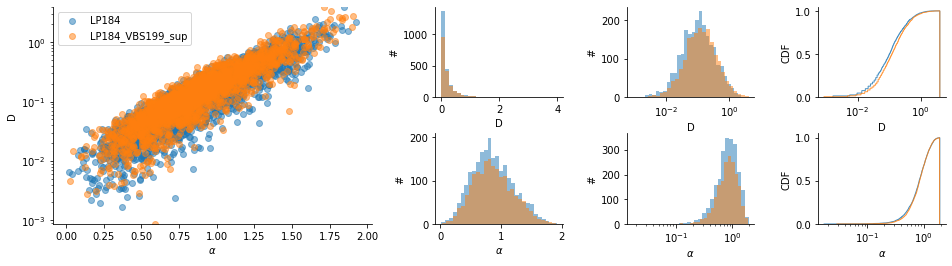

In [14]:
two_distributions_plot(DATA_LP184,DATA_WNT,"LP184","LP184_VBS199_sup")

KS statistic =  0.03028166858558247
bootstrap p-value =  0.035


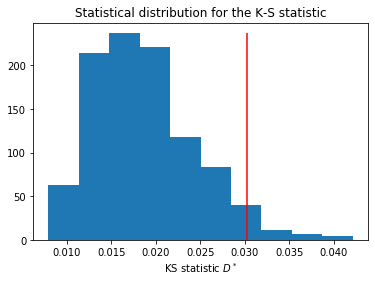

In [15]:
A1 = []
for k in range(np.shape(DATA_LP184)[0]):
    A1.append(DATA_LP184[k][0])

A2 = []
for k in range(np.shape(DATA_WNT)[0]):
    A2.append(DATA_WNT[k][0])
    
stat,pvalue = kolmogorov_smirnov(A1,A2,nloop=1000,plot=True)

### Kolmogorov - Smirnov test

We can compare the two distirbutions by performing a Kolmogorov-Smirnov test. This test looks for the maximum distance between the two cumulative distribution functions of these distributions. It returns a statistic number $D$ and evaluates a p-value. 

For some reason, in automatic mode `ks_2samp` does not evaluate properly the p-value. I assume that the `scipy` function performs a continuous fit of the statistical distribution of the $D$ statistic. Indeed, the pvalue can be evaluated experimentally by:
* concatenating the two distributions and shuffling the resulting large distribution
* splitting this large distribution into two partition respecting the size of the original distributions
* performing a two sample K-S test and obtaining $D^*$
* doing the previous steps $N$ times and counting how many times $D^* > D$, i.e. a measure of how much the directly computed $D$ is inside the statistical distribution of $D^*$. 

This probability of $D^* > D$ is the p-value. If it is 0 then all $D^*$ values are below $D$, there is no overlap, the distributions are in all likelihood different. If it is larger than 0.05 then there is at least a 5% chance that the original distributions are identical.

In [ ]:
dist1 = D_WNT
dist2 = D_LP184

stat,pvalue = kolmogorov_smirnov(dist1,dist2,1000,plot=True)